In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

In [5]:
#家の属性データのロードを行う
#なお、zipcodeが指定の数(count)以下の場合、データを捨てる
def load_house_attributes(inputPath):
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
    #key値の方をリストにする
    zipcodes = df["zipcode"].value_counts().keys().tolist()
    #カウント数の方をリストにする
    counts = df["zipcode"].value_counts().tolist()
    
    for (zipcode, count) in zip(zipcodes, counts):
        if count < 20:
            #zipcodeが一致するインデックスをidxsに格納する
            idxs = df[df["zipcode"] == zipcode].index
            #idxsの値を持つインデックスを削除する
            #inplaceの説明
            #デフォルトでは元のDataFrameは変更されず、新しいDataFrameが返される。
            #引数inplaceをTrueにすると、元のDataFrameが変更される。
            #この場合、新しいDataFrameは返されず、返り値はNone。
            df.drop(idxs, inplace=True)
            
    return df

#家の属性データ用の前処理
def preprocess_house_attributes(df, train, test):
    continuous = ["bedrooms", "bathrooms", "area"]
    
    #最小が0、最大が1になるようにする
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])
    
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    #それぞれのuniqueなzipcodeに対してone-hotエンコーディングを行う
    #zipcodeが指定の数(count)以上だけに絞る
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    #(指定のカウント数によるデータの制限はtrain_test_split前に行うため、
    #テスト用のカテゴリも学習用に一致する)
    testCategorical = zipBinarizer.transform(test["zipcode"])
    
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
    
    return (trainX, testX)

#dfのindexを使用するため、dfを引数に入れる
def load_house_images(df, inputPath):
    images = []
    
    img_size = 64
    #制限をかけた362のデータに対してループを行う
    for i in df.index.values:
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        #それぞれの家のデータセットに対して、アルファベット順に部屋画像の
        #ソートを行う
        housePaths = sorted(list(glob.glob(basePath)))
        
        inputImages = []
        outputImage = np.zeros((img_size*2, img_size*2, 3), dtype="uint8")
        
        for housePath in housePaths:
            image = cv2.imread(housePath)
            image = cv2.resize(image, (img_size, img_size))
            inputImages.append(image)
            
        outputImage[0:img_size, 0:img_size] = inputImages[0]
        outputImage[0:img_size, img_size:img_size*2] = inputImages[1]
        outputImage[img_size:img_size*2, img_size:img_size*2] = inputImages[2]
        outputImage[img_size:img_size*2, 0:img_size] = inputImages[3]
        
        images.append(outputImage)
    
    return np.array(images)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


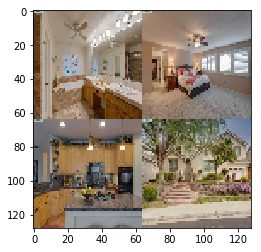

In [6]:
#前処理したデータの確認
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

df = load_house_attributes("../Houses-dataset/Houses Dataset/HousesInfo.txt")
(train, test) = train_test_split(df, test_size=0.15, random_state=42)
preprocess_house_attributes(df, train, test)
outputIMG = load_house_images(df, "../Houses-dataset/Houses Dataset")
show_img = cv2.cvtColor(outputIMG[-1], cv2.COLOR_BGR2RGB)

plt.imshow(show_img)

In [15]:
#モデルの実装
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input
from keras.models import Model

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

def create_cnn(width, height, depth, filters=(32, 64, 128, 256), regress=False):
    inputShape = (height, width, depth)
    chanDim = -1
    
    inputs = Input(shape=inputShape)
    
    for i, f in enumerate(filters):
        if i == 0:
            x = inputs
            
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    x = Flatten()(x)
    x = Dense(100)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    
    x = Dense(8)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    
    if regress:
        x = Dense(1, activation="linear")(x)
        
    model = Model(inputs, x)
    
    return model

In [34]:
#学習を行う
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.layers import concatenate, Add, Multiply
import numpy as np
import argparse
import locale
import os
from keras import backend as K
from keras.callbacks import ModelCheckpoint

print("[INFO] 家の属性データをロード開始")
inputPath = os.path.sep.join(["../Houses-dataset/Houses Dataset", "HousesInfo.txt"])
df = load_house_attributes(inputPath)

print("[INFO] 家の画像データをロード開始")
images = load_house_images(df, "../Houses-dataset/Houses Dataset")
images = images / 255.0

print("[INFO] データの処理開始")
split = train_test_split(df, images, test_size=0.10, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

(trainAttrX, testAttrX) = preprocess_house_attributes(df, trainAttrX, testAttrX)

#結合モデルの実装
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(128, 128, 3, regress=False)

combinedInput = concatenate([mlp.output, cnn.output])
#combinedInput = Multiply()([mlp.output, cnn.output])

x = Dense(4)(combinedInput)
x = Activation("relu")(x)
x = Dense(1, activation="linear")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = Adam(lr=1e-3, decay=1e-3 / 500)
#opt = RMSprop(decay=1e-3 / 200)

#print('[INFO] 重みのロード開始')
#model.load_weights('model_weights/weights.468-16.05.h5')

model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

filepath = "model_weights/weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                             save_weights_only=True, mode='auto', period=1)

print("[INFO] モデルの学習開始")
model.fit([trainAttrX, trainImagesX], trainY,
         validation_data=([testAttrX, testImagesX], testY),
         epochs=500, batch_size=8, callbacks=[checkpoint])

print("[INFO] 家の価格を予測開始")
preds = model.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

"""
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] 家の価格の平均：{}、家の価格の標準偏差：{}".format(
locale.currency(df["price"].mean(), grouping=True),
locale.currency(df["price"].std(), grouping=True)))
print("[INFO] 平均：{:.2f}%、標準偏差：{:.2f}%".format(mean, std))
"""

[INFO] 家の属性データをロード開始
[INFO] 家の画像データをロード開始
[INFO] データの処理開始


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


[INFO] モデルの学習開始
Train on 345 samples, validate on 39 samples
Epoch 1/1000
345/345 [==============================] - 10s 28ms/step - loss: 680.8632 - val_loss: 5888.5258
Epoch 2/1000
345/345 [==============================] - 1s 3ms/step - loss: 311.6880 - val_loss: 1076.1050
Epoch 3/1000
345/345 [==============================] - 1s 3ms/step - loss: 135.9355 - val_loss: 271.6287
Epoch 4/1000
345/345 [==============================] - 1s 3ms/step - loss: 104.8997 - val_loss: 126.6836
Epoch 5/1000
345/345 [==============================] - 1s 3ms/step - loss: 80.3928 - val_loss: 75.7696
Epoch 6/1000
345/345 [==============================] - 1s 3ms/step - loss: 57.0140 - val_loss: 64.7432
Epoch 7/1000
345/345 [==============================] - 1s 3ms/step - loss: 54.7185 - val_loss: 52.9508
Epoch 8/1000
345/345 [==============================] - 1s 3ms/step - loss: 52.6639 - val_loss: 52.7808
Epoch 9/1000
345/345 [==============================] - 1s 3ms/step - loss: 46.8409 - val_loss:

345/345 [==============================] - 1s 3ms/step - loss: 18.5647 - val_loss: 27.6422
Epoch 79/1000
345/345 [==============================] - 1s 3ms/step - loss: 19.7901 - val_loss: 24.4244
Epoch 80/1000
345/345 [==============================] - 1s 3ms/step - loss: 19.2791 - val_loss: 23.9829
Epoch 81/1000
345/345 [==============================] - 1s 3ms/step - loss: 18.2602 - val_loss: 23.7098
Epoch 82/1000
345/345 [==============================] - 1s 3ms/step - loss: 18.2314 - val_loss: 26.6201
Epoch 83/1000
345/345 [==============================] - 1s 3ms/step - loss: 17.6651 - val_loss: 24.8437
Epoch 84/1000
345/345 [==============================] - 1s 3ms/step - loss: 17.3819 - val_loss: 24.4865
Epoch 85/1000
345/345 [==============================] - 1s 3ms/step - loss: 17.1912 - val_loss: 23.3653
Epoch 86/1000
345/345 [==============================] - 1s 3ms/step - loss: 17.7567 - val_loss: 23.1078
Epoch 87/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 15.8008 - val_loss: 22.5159
Epoch 156/1000
345/345 [==============================] - 1s 3ms/step - loss: 15.8439 - val_loss: 23.2172
Epoch 157/1000
345/345 [==============================] - 1s 3ms/step - loss: 14.9628 - val_loss: 23.6808
Epoch 158/1000
345/345 [==============================] - 1s 3ms/step - loss: 16.5187 - val_loss: 25.4423
Epoch 159/1000
345/345 [==============================] - 1s 3ms/step - loss: 16.8795 - val_loss: 25.2664
Epoch 160/1000
345/345 [==============================] - 1s 3ms/step - loss: 15.7148 - val_loss: 23.6739
Epoch 161/1000
345/345 [==============================] - 1s 3ms/step - loss: 14.3855 - val_loss: 23.1337
Epoch 162/1000
345/345 [==============================] - 1s 3ms/step - loss: 15.9337 - val_loss: 22.6302
Epoch 163/1000
345/345 [==============================] - 1s 3ms/step - loss: 16.2152 - val_loss: 25.6098
Epoch 164/1000
345/345 [==============================] - 1s 

345/345 [==============================] - 1s 3ms/step - loss: 13.0817 - val_loss: 23.9946
Epoch 233/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.4262 - val_loss: 22.5112
Epoch 234/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.2273 - val_loss: 23.0087
Epoch 235/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.0478 - val_loss: 26.5677
Epoch 236/1000
345/345 [==============================] - 1s 3ms/step - loss: 13.2431 - val_loss: 23.3315
Epoch 237/1000
345/345 [==============================] - 1s 3ms/step - loss: 13.1927 - val_loss: 22.1140
Epoch 238/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.3901 - val_loss: 21.5703
Epoch 239/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.9014 - val_loss: 22.5954
Epoch 240/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.5637 - val_loss: 22.8533
Epoch 241/1000
345/345 [==============================] - 1s 

345/345 [==============================] - 1s 3ms/step - loss: 10.0787 - val_loss: 22.5519
Epoch 310/1000
345/345 [==============================] - 1s 3ms/step - loss: 11.3881 - val_loss: 23.1564
Epoch 311/1000
345/345 [==============================] - 1s 3ms/step - loss: 10.6382 - val_loss: 22.9192
Epoch 312/1000
345/345 [==============================] - 1s 3ms/step - loss: 11.2483 - val_loss: 20.8988
Epoch 313/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.4532 - val_loss: 22.7427
Epoch 314/1000
345/345 [==============================] - 1s 3ms/step - loss: 10.3480 - val_loss: 22.5947
Epoch 315/1000
345/345 [==============================] - 1s 3ms/step - loss: 13.2979 - val_loss: 24.8625
Epoch 316/1000
345/345 [==============================] - 1s 3ms/step - loss: 12.2004 - val_loss: 24.5033
Epoch 317/1000
345/345 [==============================] - 1s 3ms/step - loss: 11.6788 - val_loss: 23.3877
Epoch 318/1000
345/345 [==============================] - 1s 3

345/345 [==============================] - 1s 3ms/step - loss: 9.4209 - val_loss: 26.5952
Epoch 387/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.0298 - val_loss: 21.5703
Epoch 388/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.5786 - val_loss: 21.3229
Epoch 389/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.8452 - val_loss: 22.1317
Epoch 390/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.8940 - val_loss: 20.8800
Epoch 391/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.1678 - val_loss: 20.3535
Epoch 392/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.2372 - val_loss: 20.4936
Epoch 393/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.7012 - val_loss: 20.4001
Epoch 394/1000
345/345 [==============================] - 1s 3ms/step - loss: 9.7243 - val_loss: 20.4056
Epoch 395/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 8.4060 - val_loss: 22.5083
Epoch 465/1000
345/345 [==============================] - 1s 3ms/step - loss: 10.0889 - val_loss: 25.6724
Epoch 466/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.5041 - val_loss: 21.9163
Epoch 467/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.7922 - val_loss: 21.4214
Epoch 468/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.7022 - val_loss: 19.2439
Epoch 469/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.2268 - val_loss: 20.5297
Epoch 470/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.1107 - val_loss: 20.0183
Epoch 471/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.2154 - val_loss: 21.1464
Epoch 472/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.6722 - val_loss: 21.5814
Epoch 473/1000
345/345 [==============================] - 1s 3ms/step

345/345 [==============================] - 1s 3ms/step - loss: 6.5681 - val_loss: 20.7969
Epoch 543/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.8926 - val_loss: 19.8880
Epoch 544/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.0399 - val_loss: 21.4160
Epoch 545/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.4269 - val_loss: 20.4785
Epoch 546/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.2870 - val_loss: 20.6151
Epoch 547/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.2015 - val_loss: 19.5076
Epoch 548/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.7271 - val_loss: 21.3623
Epoch 549/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.2860 - val_loss: 20.5885
Epoch 550/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.4875 - val_loss: 19.9569
Epoch 551/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 8.7172 - val_loss: 20.5404
Epoch 621/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.6913 - val_loss: 19.8283
Epoch 622/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.4256 - val_loss: 21.5299
Epoch 623/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.1900 - val_loss: 21.4810
Epoch 624/1000
345/345 [==============================] - 1s 3ms/step - loss: 8.5281 - val_loss: 20.5954
Epoch 625/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.2036 - val_loss: 20.9880
Epoch 626/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.2678 - val_loss: 20.2491
Epoch 627/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.6752 - val_loss: 20.7918
Epoch 628/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.6656 - val_loss: 20.5606
Epoch 629/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 6.5206 - val_loss: 21.5772
Epoch 699/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.8961 - val_loss: 21.0299
Epoch 700/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.9172 - val_loss: 21.1527
Epoch 701/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.6200 - val_loss: 20.3219
Epoch 702/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.3761 - val_loss: 20.5616
Epoch 703/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.1803 - val_loss: 21.1260
Epoch 704/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.5270 - val_loss: 20.3832
Epoch 705/1000
345/345 [==============================] - 1s 3ms/step - loss: 7.1353 - val_loss: 19.3315
Epoch 706/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.4934 - val_loss: 20.8695
Epoch 707/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 5.6938 - val_loss: 20.3903
Epoch 777/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.9793 - val_loss: 20.0169
Epoch 778/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.2270 - val_loss: 20.3857
Epoch 779/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.9840 - val_loss: 19.7667
Epoch 780/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.4079 - val_loss: 20.0958
Epoch 781/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.4096 - val_loss: 19.9055
Epoch 782/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.0919 - val_loss: 20.5250
Epoch 783/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.4785 - val_loss: 20.5854
Epoch 784/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.8724 - val_loss: 21.1287
Epoch 785/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 6.8719 - val_loss: 20.0610
Epoch 855/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.1808 - val_loss: 20.0110
Epoch 856/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.2271 - val_loss: 20.3826
Epoch 857/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.8326 - val_loss: 20.7629
Epoch 858/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.1915 - val_loss: 20.2132
Epoch 859/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.2610 - val_loss: 22.8956
Epoch 860/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.9741 - val_loss: 19.4229
Epoch 861/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.9709 - val_loss: 19.8611
Epoch 862/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.4496 - val_loss: 19.7911
Epoch 863/1000
345/345 [==============================] - 1s 3ms/step 

345/345 [==============================] - 1s 3ms/step - loss: 5.7137 - val_loss: 22.0501
Epoch 933/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.2562 - val_loss: 20.1110
Epoch 934/1000
345/345 [==============================] - 1s 3ms/step - loss: 6.2283 - val_loss: 20.3029
Epoch 935/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.4414 - val_loss: 21.1445
Epoch 936/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.6578 - val_loss: 19.9774
Epoch 937/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.6557 - val_loss: 20.1150
Epoch 938/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.4971 - val_loss: 20.0674
Epoch 939/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.2069 - val_loss: 20.0323
Epoch 940/1000
345/345 [==============================] - 1s 3ms/step - loss: 5.5612 - val_loss: 20.4342
Epoch 941/1000
345/345 [==============================] - 1s 3ms/step 

'\nlocale.setlocale(locale.LC_ALL, "en_US.UTF-8")\nprint("[INFO] 家の価格の平均：{}、家の価格の標準偏差：{}".format(\nlocale.currency(df["price"].mean(), grouping=True),\nlocale.currency(df["price"].std(), grouping=True)))\nprint("[INFO] 平均：{:.2f}%、標準偏差：{:.2f}%".format(mean, std))\n'

In [ ]:
cnn = create_cnn(128, 128, 3, regress=False)
cnn.summary()

In [21]:
mlp = create_mlp(trainAttrX.shape[1], regress=False)
mlp.output

<tf.Tensor 'dense_17/Relu:0' shape=(?, 4) dtype=float32>

In [19]:
cnn.output

<tf.Tensor 'activation_15/Relu:0' shape=(?, 10) dtype=float32>

In [20]:
combinedInput.shape

TensorShape([Dimension(None), Dimension(12)])

In [25]:
K.get_value(mlp.output + cnn.output)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,128,128,3]
	 [[Node: input_5 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: add_1/_1411 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_388_add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input_5', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-7532c67a2ca1>", line 33, in <module>
    cnn = create_cnn(128, 128, 3, regress=False)
  File "<ipython-input-22-c5cee8d60262>", line 26, in create_cnn
    inputs = Input(shape=inputShape)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1746, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_5' with dtype float and shape [?,128,128,3]
	 [[Node: input_5 = Placeholder[dtype=DT_FLOAT, shape=[?,128,128,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: add_1/_1411 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_388_add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
